# Problem 1

In [30]:
import torch
import torch.utils.data as data 
import torch.nn as nn
from torch.distributions.normal import Normal 
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt

In [31]:
epochs = 200
learning_rate = 5e-3
batch_size = 128
n_components=5 # the number of kernel
target_distribution = Normal(0.0, 1.0)

In [32]:
####################################
# STEP 1: Implement 1-d Flow model #
# Model is misture of Gaussian CDFs
#
####################################
class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.exp()
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (weights * (distribution.cdf(x) - 0.5)).sum(dim=1)

        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z, dz_by_dx

In [33]:
################################################
# STEP 2: Create Dataset and Create Dataloader #
################################################ 

def mixture_of_gaussians(num, mu_var=(-1,0.25, 0.2,0.25, 1.5,0.25)):
    n = num // 3
    m1,s1,m2,s2,m3,s3 = mu_var
    gaussian1 = np.random.normal(loc=m1, scale=s1, size=(n,))
    gaussian2 = np.random.normal(loc=m2, scale=s2, size=(n,))
    gaussian3 = np.random.normal(loc=m3, scale=s3, size=(num-n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])

class MyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]

In [34]:
################################
# STEP 3: Define Loss Function #
################################
def loss_function(target_distribution, z, dz_by_dx):
    # log(p_Z(z)) = target_distribution.log_prob(z)
    # log(dz/dx) = dz_by_dx.log() (flow is defined so that dz/dx>0)
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()  #flip sign, and sum of data X_1,...X_N

In [35]:
###########################
# STEP 4: Train the model #
########################### 

# create dataloader
n_train, n_test = 5000, 1000
train_data = mixture_of_gaussians(n_train)
test_data = mixture_of_gaussians(n_test)

train_loader = data.DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(MyDataset(test_data), batch_size=batch_size, shuffle=True)

# create model
flow = Flow1d(n_components)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for epoch in range(epochs):
    # train
#     flow.train()
    mean_loss = 0
    for i, x in enumerate(train_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    train_losses.append(mean_loss/(i+1))

    # test
    flow.eval()
    mean_loss = 0
    for i, x in enumerate(test_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)

        mean_loss += loss.item()
    test_losses.append(mean_loss/(i+1))

## Visualize training and test data

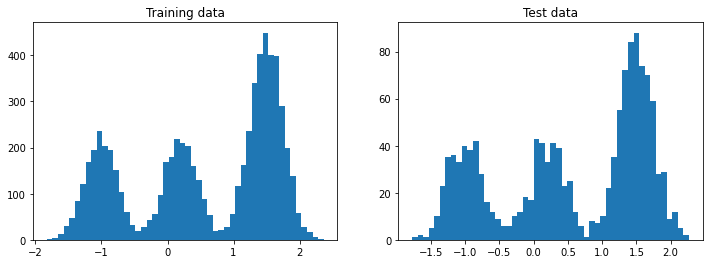

In [36]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Test data')

## View training and test loss

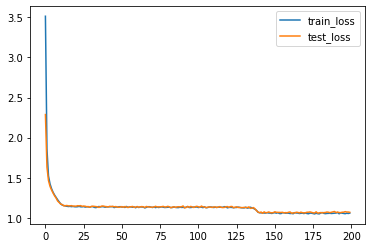

In [37]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

## View learned distribution and flow map

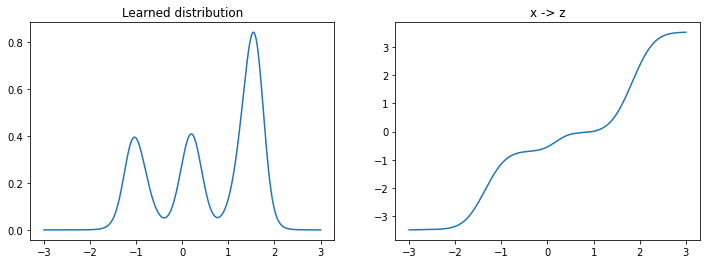

In [38]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

## View learned $p_Z$, which is trained to be N(0,1).

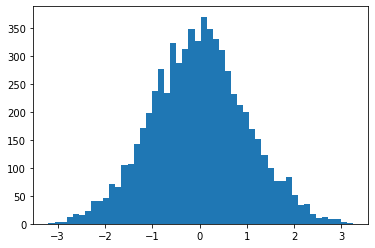

In [39]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    
_ = plt.hist(np.array(z), bins=50)

## Sampling X

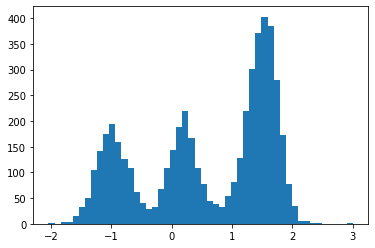

In [42]:
# sampling

N = 5000
z = torch.normal(0,1, size = (N,))
x_low = torch.full((N,), -3.)
x_high = torch.full((N,), 3.)

#Perform bisection
with torch.no_grad():
    for _ in range(30):
        m = (x_low+x_high)/2
        f,_ = flow(m)
        x_high[f>=z] = m[f>=z]
        x_low[f<z] = m[f<z]
    x = (x_low+x_high)/2

_ = plt.hist(np.array(x), bins=50)


# Problem 6

$$
\hat{I}_N=
\frac{1}{N}\sum^N_{i=1} \phi(Y_{i1},\dots ,Y_{iK}) \prod^K_{j=1}p^{Y_{ij}}(1-p)^{1-Y_{ij}} / \prod^K_{j=1}q^{Y_{ij}}(1-q)^{1-Y_{ij}}\\
=
\frac{1}{N}\sum^N_{i=1} \phi(Y_{i1},\dots ,Y_{iK}) \prod^K_{j=1}(\frac{p}{q})^{Y_{ij}}(\frac{1-p}{1-q})^{1-Y_{ij}}\\
$$
where $Y_i\sim \mathcal{Ber}(0.55)$, $\phi(Y_{i1},\dots ,Y_{iK})$ denotes indicator to leave with 200$.

In [2]:
import numpy as np

In [9]:
N = 3000
K = 600
p = 18/37
q = 0.55

In [11]:
def round(ber):
    balance = 100
    for result in ber:
        balance += 2 * result - 1
        if balance == 0 | balance == 200:
            break;
    if balance == 200: return 1
    else: return 0

In [35]:
sample = np.empty([N,], dtype=float)
for n in range(N):
    ber = np.random.binomial(1, q, K)
    sample[n] = round(ber) * (p/q) ** ber.sum() * ((1-p)/(1-q)) ** (K-ber.sum())

Ihat = sample.mean()
print(format(Ihat, ".1e"))

2.1e-06


# Problem 7

## (a) log-derivative trick

In [81]:
import torch
from torch.distributions.normal import Normal 
import math

mu = torch.tensor([0.])
tau = torch.tensor([0.]) # tau = log_sigma
lr = 1e-2
B = 16
iterations = 100

for itr in range(iterations):
    dist = Normal(mu, tau.exp())
    X = dist.sample((B,))
    g_mu = (X * torch.sin(X) * (X - mu) / (2*tau).exp()).mean() + mu - 1
    g_tau = (X * torch.sin(X) * ((X - mu) ** 2 / (2*tau).exp() - 1)).mean() + tau.exp() - 1
    mu -= lr*g_mu
    tau -= lr*g_tau
    
print("mu:", format(mu.item(), ".3f"))
print("sigma:", format(tau.exp().item(), ".3f"))

mu: 0.447
sigma: 0.683


## (b) reparameterization trick

In [79]:
import torch
import math

mu = torch.tensor([0.])
tau = torch.tensor([0.]) # tau = log_sigma
lr = 1e-2
B = 16
iterations = 10000

for itr in range(iterations):
    dist = Normal(0, 1)
    Y = dist.sample((B,))
    X = mu + tau.exp() * Y
    phi_prime = torch.sin(X) + X * torch.cos(X)
    g_mu = phi_prime.mean() + mu - 1
    g_tau = (Y * phi_prime * tau.exp()).mean() + tau.exp() - 1
    mu -= lr*g_mu
    tau -= lr*g_tau
   
print("mu:", format(mu.item(), ".3f"))
print("sigma:", format(tau.exp().item(), ".3f"))

mu: 0.454
sigma: 0.611
